In [1]:
import os
import torch
import pickle
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import os
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv, global_mean_pool

%run ../Config.ipynb
config = Config()

from torch_geometric.data import Data, Dataset
from collections import Counter

In [2]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)
#bipartite_no_pose_rank_cut_4_coreset_RAND_ENCODED_POSERANK
with open(f'{config.data}/bipartite_data_with_pose_pred.pkl', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

##### Filter data list 

filtered_data_list_num_nodes = [data for data in dataset_list_opened if data.num_nodes>0]
filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

filtered_data_list = filtered_data_list_descriptors.copy()

label_distribuition = dict(Counter([label.y.tolist() for label in filtered_data_list]))
amount_of_graphs_used_to_train = len(filtered_data_list)

filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

len(filtered_data_list)

filtered_data_list[0]

class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels=input_dim, out_channels=600, heads=2)
        #self.conv2 = GATConv(in_channels=100, out_channels=hidden_dim, heads=1)
        self.fc1 = nn.Linear(600*2, 10)
        
        self.fc3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, data):
        x_s, x_t, edge_index, distances, x_t_batch, x_s_batch = data.x_s, data.x_t, data.edge_index, data.edge_attr, data.x_t_batch, data.x_s_batch
        x_new_t = self.conv1((x_s, x_t), edge_index, size=(x_s.size(0), x_t.size(0)), edge_attr=distances)
        x = torch.relu(x_new_t)

        ##########3
        #x_new_s = self.conv2((x_t, x_s), edge_index[torch.tensor([1, 0])], size=(x_t.size(0), x_s.size(0)), edge_attr=distances)
        #x = torch.relu(x_new_s)
        #####################
        x = global_mean_pool(x, x_s_batch)
        x = self.fc1(x)
        #x = self.fc2(x)

        #x = self.dropout(x)
        x = self.fc3(x)
        #print('x: ', x)
        return x.squeeze()

class BalancedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight=None, reduction='mean'):
        super(BalancedBCEWithLogitsLoss, self).__init__()
        self.pos_weight = pos_weight
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction=reduction)

    def forward(self, input, target):
        loss = self.bce_loss(input, target)
        return loss

loader = DataLoader(filtered_data_list[1500:], batch_size=config.model_args["batch_size"], shuffle=True, follow_batch=['x_s', 'x_t'])
criterion = BalancedBCEWithLogitsLoss(pos_weight=torch.tensor(11.5))
#[1500:1938],
import re

def predict(model, data):
    # Preprocess your data here if necessary
    # Convert your data into tensors or any format expected by your model
    # For example:
    model.eval()
    val_probs = {}
    true_label = {}
    # Forward pass through the model
    with torch.no_grad():
        for batch_data in data:
            output = model(batch_data)
            val_probs[str(batch_data.pdb), str(batch_data.pose)] = torch.sigmoid(output).item()  # Obtain probabilities using sigmoid function
            true_label[str(batch_data.pdb), str(batch_data.pose)] =  batch_data.y.item()
    return val_probs, true_label

best_model = GATModel(input_dim=12, hidden_dim=12, batch_size=config.model_args["batch_size"])
best_model.load_state_dict(torch.load('../Model/model_183.pt'))
best_model.eval()
# Make predictions using the best_model and criterion
predictions,true_label = predict(best_model, loader)

/home/lbcb02/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
len(filtered_data_list)

1948

In [4]:
1948 - 1500

448

#### Convert dictionary to DataFrame

In [5]:
# Convert dictionary to DataFrame
df = pd.DataFrame(predictions.items(), columns=['Index', 'Pred'])

# Extract values from 'Index' column using regular expressions
df[['pdb', 'pose']] = df['Index'].apply(lambda x: pd.Series(re.findall(r"'(\w+)'", x[0]) + re.findall(r'\[(\d+)\]', x[1])))

df['label'] = list(true_label.values())
# Drop the original 'Index' column
df.drop('Index', axis=1, inplace=True)

In [6]:
len(df)

448

In [7]:
df.sort_values(['pdb','pose']).head()

,Pred,pdb,pose,label
377,0.612179,1a30,1,0.0
116,0.120718,1a30,3,0.0
15,0.095587,1a30,9,0.0
191,0.141282,1bcu,4,0.0
125,0.130671,1bcu,9,0.0


In [8]:
df['label'].value_counts()

0.0    409
1.0     39
Name: label, dtype: int64

In [9]:
df.sort_values(['pdb','pose']).head()

,Pred,pdb,pose,label
377,0.612179,1a30,1,0.0
116,0.120718,1a30,3,0.0
15,0.095587,1a30,9,0.0
191,0.141282,1bcu,4,0.0
125,0.130671,1bcu,9,0.0


In [10]:
df[(df['pose'] == '8') & (df['label']==1)]

,Pred,pdb,pose,label
291,0.095578,2cet,8,1.0


In [11]:
df_filtered = df[df['pose'] != "1"]

In [12]:
df_filtered.sort_values('Pred', ascending = False)

,Pred,pdb,pose,label
70,0.284821,1sqa,2,0.0
43,0.263490,1c5z,2,0.0
396,0.258572,4m0y,2,0.0
356,0.240515,2v00,2,0.0
196,0.229993,3b65,2,0.0
...,...,...,...,...
199,0.039389,3zdg,4,0.0
108,0.036197,3u9q,8,0.0
36,0.035843,3nq9,5,0.0
283,0.033747,3uex,6,0.0


In [13]:
df[df['pdb'] == '1sqa']

,Pred,pdb,pose,label
70,0.284821,1sqa,2,0.0
95,0.808427,1sqa,1,0.0
197,0.153042,1sqa,7,0.0
259,0.130890,1sqa,9,0.0


In [14]:
df[df['pdb'] == '1c5z']

,Pred,pdb,pose,label
7,0.125687,1c5z,7,0.0
20,0.153117,1c5z,9,0.0
43,0.263490,1c5z,2,0.0
81,0.123549,1c5z,6,0.0


In [15]:
df[df['pdb'] == '3prs']

,Pred,pdb,pose,label
22,0.132865,3prs,2,0.0
32,0.081356,3prs,6,0.0
85,0.116633,3prs,3,1.0
90,0.084484,3prs,7,0.0


In [16]:
df[df['pdb'] == '2cet']

,Pred,pdb,pose,label
291,0.095578,2cet,8,1.0
348,0.103164,2cet,4,1.0
366,0.102774,2cet,6,1.0


<Axes: xlabel='Pred', ylabel='Density'>

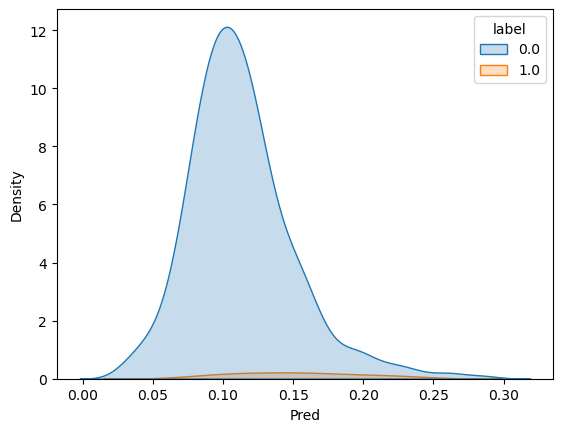

In [17]:
sns.kdeplot(data=df[df['pose'] != "1"], x='Pred', hue='label', fill=True)

<Axes: xlabel='Pred', ylabel='Density'>

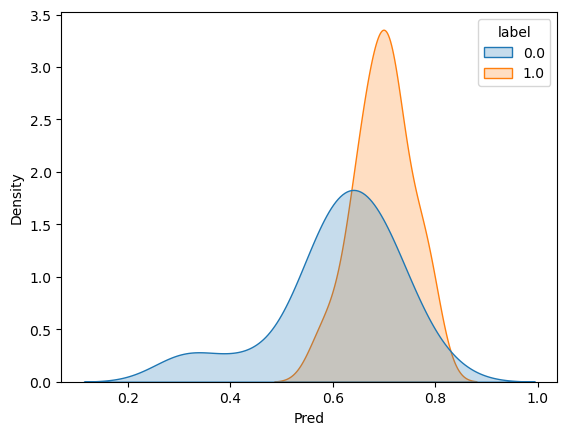

In [18]:
sns.kdeplot(data=df[df['pose'] == "1"], x='Pred', hue='label', fill=True)

#### Best ranked 

In [19]:
df = df.sort_values(['pdb','Pred'], ascending = False)
df['label'] = df['label'].astype(int)

In [20]:
top_ranked = df.loc[df.groupby('pdb')['Pred'].idxmax()]

#### My ranking ( RMSD and Scoring): Top sorted by model pred

In [21]:
label_counts = df.groupby('pdb')['label'].sum().sort_values(ascending = False).reset_index()

In [22]:
label_counts['label'].value_counts()

0    162
1     34
3      1
2      1
Name: label, dtype: int64

In [23]:
label_counts.head()

,pdb,label
0,2cet,3
1,1vso,2
2,3ebp,1
3,4f09,1
4,3fur,1


In [24]:
pdbs_with_pose_1 = list(df[df['pose'] == '1']['pdb'])

In [25]:
pdbs_teste_set_with_atleast_one_correct_post = list(label_counts[label_counts['label'] > 0 ]['pdb'])

In [26]:
conjunto =  set(pdbs_teste_set_with_atleast_one_correct_post) and set(pdbs_with_pose_1)

In [27]:
top_ranked = top_ranked[top_ranked['pdb'].isin(conjunto)]

In [51]:
top_ranked.shape

(54, 4)

In [28]:
top_ranked[top_ranked['label'] == 1].shape[0] / top_ranked.shape[0]

0.5

In [53]:
df['pdb'].nunique()

54

In [30]:
top_ranked.shape[0]

54

#### Vina Fraction of top-ranked

In [31]:
df = df[df['pdb'].isin(conjunto)]

In [32]:
df[(df['pose']=="1") & (df['label']==1)].shape[0] /df['pdb'].nunique()

0.5

In [33]:
df[df['pdb'] == '2cet']

,Pred,pdb,pose,label


In [34]:
top_ranked[top_ranked['label'] == 1]

,Pred,pdb,pose,label
235,0.784238,1nc3,1,1
39,0.695849,1ps3,1,1
177,0.670355,1qf1,1,1
0,0.769849,1s38,1,1
242,0.662293,1vso,1,1
399,0.762556,1y6r,1,1
163,0.732615,2j78,1,1
156,0.629486,2p4y,1,1
213,0.714215,2pog,1,1
284,0.639606,2vw5,1,1


In [35]:
df[(df['pose']=="1") & (df['label']==1)]

,Pred,pdb,pose,label
218,0.778608,4m0z,1,1
193,0.718629,4j21,1,1
172,0.652639,4ivc,1,1
350,0.677449,4gid,1,1
56,0.724938,4f09,1,1
138,0.679562,3uuo,1,1
363,0.595520,3ui7,1,1
130,0.689285,3r88,1,1
365,0.706736,3nw9,1,1
258,0.641332,3gbb,1,1


#### Prediction distribuition 

In [36]:
df['binary_pred'] = df['Pred'].apply(lambda val: 0 if val <= 0.5 else 1)

In [37]:
df['binary_pred'].value_counts()

0    99
1    50
Name: binary_pred, dtype: int64

#### Label distribuition 

In [38]:
df['label'].value_counts()

0    120
1     29
Name: label, dtype: int64

#### Compparando resultados 

In [39]:
top_ranked['label'].value_counts()

0    27
1    27
Name: label, dtype: int64

#### Segunda validação  

In [40]:
new_df = pd.DataFrame([(item.pdb, item.pose, round(item.y.item())) for item in filtered_data_list], columns=['pdb', 'pose', 'y'])

In [41]:
teste = new_df[1500:]

In [42]:
teste['y'].value_counts()

0    409
1     39
Name: y, dtype: int64

In [43]:
teste[ teste['pose'] == 1 ]['y'].value_counts()

1    27
0    27
Name: y, dtype: int64

In [44]:
27 / (27+27)

0.5

In [45]:
27 / (27+27)

0.5

In [46]:
prob = 102 / (102+129)

In [47]:
prob

0.44155844155844154

In [48]:
teste[ teste['pose'] != 1 ]['y'].value_counts()

0    382
1     12
Name: y, dtype: int64

In [49]:
27 / (27+12)

0.6923076923076923

In [50]:
def calculate_f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

# Example usage:
precision = 0.5
recall = 0.69
f1_score = calculate_f1_score(precision, recall)
print(f"F1 Score: {f1_score:.2f}")


F1 Score: 0.58
